In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Sersic2D
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

In [2]:
image = np.loadtxt("team_6_order_2.txt")

In [3]:
np.shape(image)
len(image[0])
#plt.matshow(image)

121

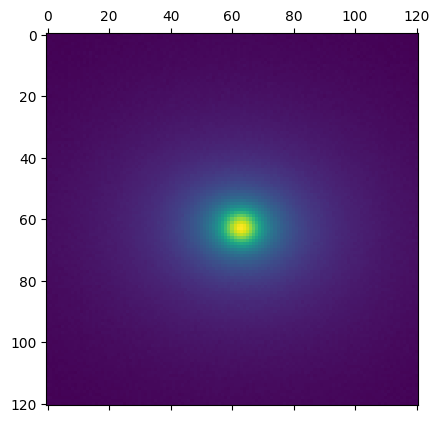

In [4]:
noise = np.sqrt(image*600)/600
signal_to_noise = image/noise
plt.matshow(signal_to_noise)

In [68]:
def sersic_model(amplitude, r_eff,x_0, y_0, q, theta):
    x,y = np.meshgrid(np.arange(121), np.arange(121))

    sersic = Sersic2D(amplitude = amplitude, r_eff = r_eff, n=4, x_0=x_0, y_0=y_0,
               ellip=1 - q, theta=theta)
    sers_img = sersic(x, y)
    std = 6 /(2*np.sqrt(2*np.log(2)))
    kernel = Gaussian2DKernel(x_stddev=std,y_stddev=std)
    conv = convolve(sers_img,kernel)
    return conv

In [69]:
def log_prior(params):
    amplitude, r_eff, x_0, y_0, q, theta = params
    if amplitude > 0 and 0 < r_eff < 60 and 0<x_0<121 and 0<y_0<121 and 0.4 < q < 1 and 0 < theta < np.pi :
        return 0.0
    return -np.inf

def log_likelihood(params):
    model = sersic_model(*params)
    std = noise**2
    return -0.5 * np.sum((image - model) ** 2 / std)
def log_posterior(params):
    prior = log_prior(params)
    
    if np.isinf(prior):
        return -np.inf
    else:
        return log_likelihood(params) + prior

In [70]:
import emcee # import the emcee package

init_params = np.array([1, 24, 61, 61, 0.9, 3]) # insert your initial guess for the model parameters
num_step = 1000
num_walkers = 40
num_params = len(init_params)
init_walker_positions = np.random.normal(loc=init_params, scale=1e-4,
                                        size=(num_walkers, num_params))

sampler = emcee.EnsembleSampler(num_walkers, num_params,
                                log_posterior)

sampler.run_mcmc(init_walker_positions, num_step, progress=True);

100%|██████████| 1000/1000 [10:29<00:00,  1.59it/s]


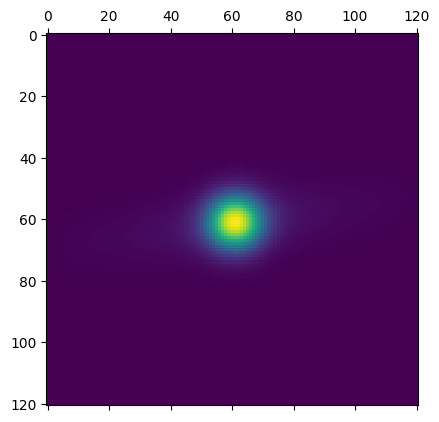

In [49]:
model_init = sersic_model(init_params)
plt.matshow(model_init)

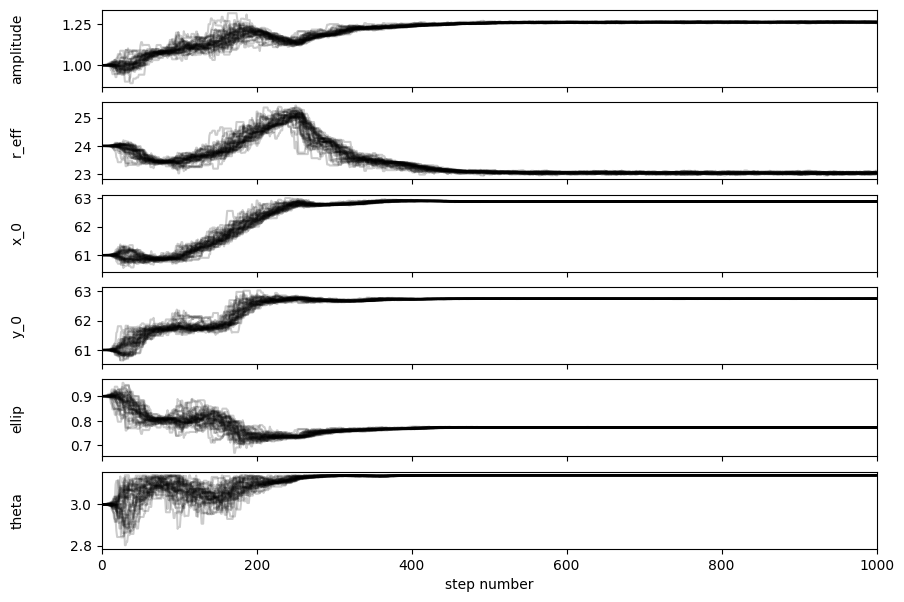

In [71]:
fig, axes = plt.subplots(num_params, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
labels = ["amplitude", "r_eff","x_0", "y_0", "ellip", "theta"] # make a list of strings for the labels of your model parameters

for i in range(num_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [76]:
from IPython.display import display, Math
discard = 450
flat_samples = sampler.get_chain(discard=discard, thin=15, flat=True)

for i in range(num_params):
    percentile_16, median, percentile_84 = np.percentile(
        flat_samples[:, i], [16, 50, 84])

    text = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}"
    text = text.format(median,
                       median - percentile_16,
                       percentile_84 - median,
                       labels[i])
    display(Math(text))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>